[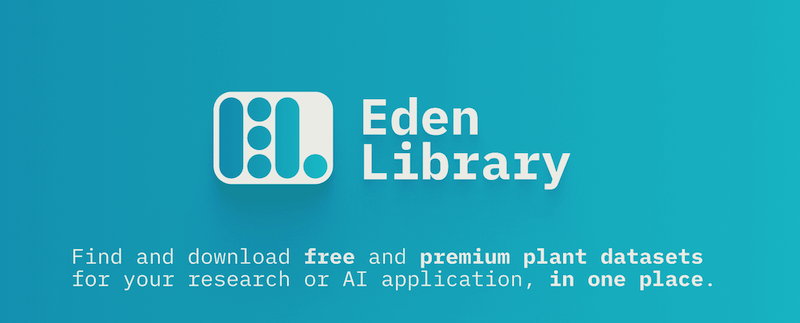](http://edenlibrary.ai/)

# Weeds Identification-Transfer Learning-2

### Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Cotton-Gossypium Herbaceum-100619-Healthy-zz
   2. Velvet leaf-Abutilon Theophrasti-220519-Weed-zz
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'cotton_weeds'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * working_directory/
       * Cotton-Velvetleaf Transfer Learning with Inception.ipynb
       * eden_data/
           * Cotton-Gossypium Herbaceum-100619-Healthy-zz
           * Velvet leaf-Abutilon Theophrasti-220519-Weed-zz
7. Install notebook dependencies by running:
    <pre><code>conda create -n name_of_environment --file eden-package-list.txt</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

## Background
In this notebook, we are gonna cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only part of the layers of the network, which was previously trained. Its promise is that the training will be more efficient and in the best of the cases the performance will be better in comparison to a model trained from scratch.

In **agriculture**, several works have arisen in the previous years. Wang et al., (2017) used transfer learning in order to obtain the best neural-based method for disease detection in plants. In Suh et al., (2018), the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Another relevant study has been performed by Kounalakis et al., (2019) where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Finally, in Espejo-Garcia et al., (2020), authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species.

#### Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

import math
import random
import matplotlib.pyplot as plt

#### Auxiliar Functions

In [9]:
def denormalise(values):
    y_den = []
    for dist in values:
        y_den.append(np.argmax(dist))
    
    return y_den

In [10]:
def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])

In [11]:
def read_data(path, tag2idx, im_size=(128,128)):
    X = []
    y = []
    for im_file in tqdm(glob(path)):
        try:
            label = im_file.split("/")[1]
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
            y.append(tag2idx[label])
        except Exception as e:
            print(e)
    
    X = np.array(X)
    y = np.array(to_categorical(y))
    return X, y

In [12]:
def get_callbacks(weights_file, patience, lr_factor):
    return [
        ModelCheckpoint(filepath= weights_file,
                        monitor="val_accuracy",
                        mode="max",
                        save_best_only=True, 
                        save_weights_only=True),
        EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience = patience,
                      verbose=1),
        ReduceLROnPlateau(monitor="val_loss", mode="min",
                          factor=lr_factor, min_lr=1e-6)]

#### Experimental Constants

In [13]:
INPUT_SHAPE = (128, 128, 3)
IM_SIZE = (128, 128)
EPOCHS = 50
BATCH_SIZE = 8
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
RANDOM_STATE = 2020
WEIGHTS_FILE = "weights.h5"

#### Reading and showing pictures

In [8]:
path = 'eden_data/'
tag2idx = {tag:i for i, tag in enumerate(os.listdir(path))}
path = 'eden_data/*/*'
X, y = read_data(path, tag2idx, IM_SIZE)

 37%|███▋      | 62/168 [00:09<00:14,  7.41it/s]

OpenCV(4.4.0) /tmp/pip-req-build-6amqbhlx/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 168/168 [00:26<00:00,  6.09it/s]


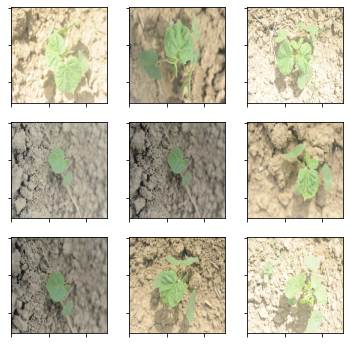

In [18]:
# Class 0
plot_sample(X[:50])

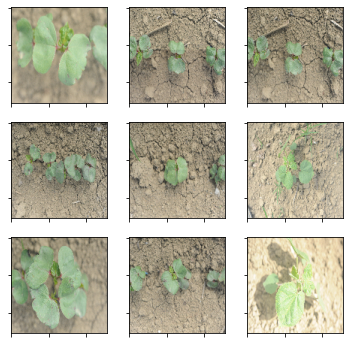

In [19]:
# Class 1
plot_sample(X[-50:])

#### Architecture Definition

In [34]:
def get_architecture(y):
    feature_extractor = InceptionV3(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False, # Do not include the ImageNet classifier at the top.
        input_shape=INPUT_SHAPE)  

    # Unfreeze the base_model
    feature_extractor.trainable = True

    # Create new model on top
    x = Flatten(name="flatten")(feature_extractor.output)
    x = Dense(units=100, activation="relu")(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    out = Dense(units=y.shape[1], 
                activation="softmax")(x)
    model = Model(feature_extractor.input, out)

    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=0.0001),
                  metrics=["accuracy"])
    
    return model

#### Data preprocessing and dataset splitting among train-val-test sets

In [35]:
X_prep = preprocess_input(X)

X_train, X_test, y_train, y_test = train_test_split(X_prep, y,
                                                    test_size=TEST_SPLIT, 
                                                    random_state = RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=VAL_SPLIT, 
                                                    random_state = RANDOM_STATE)

#### Loading Deep Neural Network

In [36]:
model = get_architecture(y)

#### Training

In [37]:
%%time
model.fit(X_train, 
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_val, y_val),
          callbacks=get_callbacks(WEIGHTS_FILE, 
                                  EPOCHS//5, 
                                  0.25))

Epoch 1/50
16/16 [==============================] - 2s 118ms/step - loss: 0.6346 - accuracy: 0.6587 - val_loss: 0.8079 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.3613 - accuracy: 0.8730 - val_loss: 1.4179 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.2356 - accuracy: 0.9286 - val_loss: 1.3924 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.1892 - accuracy: 0.9206 - val_loss: 0.5601 - val_accuracy: 0.8696 - lr: 1.0000e-04
Epoch 5/50
16/16 [==============================] - 1s 33ms/step - loss: 0.1106 - accuracy: 0.9603 - val_loss: 0.4807 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 6/50
16/16 [==============================] - 1s 58ms/step - loss: 0.1215 - accuracy: 0.9603 - val_loss: 0.1592 - val_accuracy: 0.9565 - lr: 1.0000e-04
Epoch 7/50
16/16 [==============================] -

#### Final performance

In [39]:
model.load_weights(WEIGHTS_FILE)
f1_score(denormalise(y_test), 
         denormalise(model.predict(X_test)),
         average='micro')

0.8518518518518519

## Possible Extensions
1. Evaluate the model with other metrics.
2. Try different dropout rates and neurons in the fully-connected part of the network.
3. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).